In [56]:
import os
import gdown
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Input, Dense, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split

In [2]:
files_to_download = [
    {'id': '1XP7aWc8AqALFA5HofiC6FQOI5rJ6SVc9', 'name': 'Dataset.zip'},
    {'id': '1pzknl3RgnAmMEutPoKJ0iiPcDepDAN8y', 'name': 'idm_baru.csv'}
]

def download_file(file_id, output_file):
    download_url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(download_url, output_file, quiet=False)

for file in files_to_download:
    download_file(file['id'], file['name'])

with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall("Data/")

Downloading...
From: https://drive.google.com/uc?id=1XP7aWc8AqALFA5HofiC6FQOI5rJ6SVc9
To: c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\Dataset.zip
100%|██████████| 5.17M/5.17M [00:20<00:00, 258kB/s] 
Downloading...
From: https://drive.google.com/uc?id=1pzknl3RgnAmMEutPoKJ0iiPcDepDAN8y
To: c:\Users\LENOVO\Documents\KULIAH\Magang KKP\Kode Python\REPO\Model\idm_baru.csv
100%|██████████| 74.1k/74.1k [00:03<00:00, 22.2kB/s]


In [57]:
day_path = 'Data/Dataset/Daylight'
night_path = 'Data/Dataset/NTL'
metadata = 'Data/idm_baru.csv'

In [58]:
idm_df = pd.read_csv(metadata)
idm_df.head()

,KABUPATEN,KECAMATAN,KODE BPS,DESA,IKS,IKE,IKL,IDM,KATEGORI IDM,BINARY STATUS
0,ACEH UTARA,SAWANG,1111010001,RISEH TUNONG,0.56,3667.00,3333.0,0.42,SANGAT TERTINGGAL,TERTINGGAL
1,ACEH UTARA,SAWANG,1111010002,GUNCI,7029.00,4167.00,3333.0,4843.00,SANGAT TERTINGGAL,TERTINGGAL
2,ACEH UTARA,SAWANG,1111010003,KUBU,6914.00,4667.00,4667.0,5416.00,TERTINGGAL,TERTINGGAL
3,ACEH UTARA,SAWANG,1111010004,BLANG CUT,6514.00,3333.00,4667.0,4838.00,SANGAT TERTINGGAL,TERTINGGAL
4,ACEH UTARA,SAWANG,1111010005,RISEH TEUNGOH,5714.00,0.45,5333.0,5183.00,TERTINGGAL,TERTINGGAL


In [59]:
idm_df_filtered = idm_df[['KODE BPS', 'KECAMATAN', 'DESA', 'BINARY STATUS']]
idm_df_filtered

,KODE BPS,KECAMATAN,DESA,BINARY STATUS
0,1111010001,SAWANG,RISEH TUNONG,TERTINGGAL
1,1111010002,SAWANG,GUNCI,TERTINGGAL
2,1111010003,SAWANG,KUBU,TERTINGGAL
3,1111010004,SAWANG,BLANG CUT,TERTINGGAL
4,1111010005,SAWANG,RISEH TEUNGOH,TERTINGGAL
...,...,...,...,...
846,1111041003,GEUREDONG PASE,KRUENG MBANG,TERTINGGAL
847,1111041002,GEUREDONG PASE,PULO MEURIA,TERTINGGAL
848,1111041001,GEUREDONG PASE,SUKA DAMAI,MAJU
849,1111022002,BANDA BARO,ALUE KEURINYAI,MAJU


In [69]:
def match_images_with_metadata(image_files, metadata, is_night=False):
    image_data = []
    for img_path in image_files:
        img_name = os.path.basename(img_path)
        if is_night:
            village_code = img_name.split('.')[0]
        else:
            village_code = img_name.split('-')[0]
        village_info = metadata[metadata['KODE BPS'] == int(village_code)]
        if not village_info.empty:
            kecamatan = village_info['KECAMATAN'].values[0]
            desa = village_info['DESA'].values[0]
            status = village_info['BINARY STATUS'].values[0]
            image_data.append({
                'id' : village_code,
                'filename': img_name,
                'filepath': img_path,
                'kecamatan': kecamatan,
                'desa': desa,
                'status': status
            })
    return pd.DataFrame(image_data)

In [70]:
day_files = [os.path.join(root, file) 
             for root, _, files in os.walk(day_path) 
             for file in files]
day_files[:10]

['Data/Dataset/Daylight\\MAJU\\1111010008-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010008-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010023-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010023-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010024-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010024-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010027-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010027-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010034-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010034-s.png']

In [71]:
night_files = [os.path.join(root, file) 
               for root, _, files in os.walk(night_path) 
               for file in files]

night_files[:10]

['Data/Dataset/NTL\\MAJU\\1111010008.png',
 'Data/Dataset/NTL\\MAJU\\1111010023.png',
 'Data/Dataset/NTL\\MAJU\\1111010024.png',
 'Data/Dataset/NTL\\MAJU\\1111010027.png',
 'Data/Dataset/NTL\\MAJU\\1111010034.png',
 'Data/Dataset/NTL\\MAJU\\1111020014.png',
 'Data/Dataset/NTL\\MAJU\\1111020019.png',
 'Data/Dataset/NTL\\MAJU\\1111020023.png',
 'Data/Dataset/NTL\\MAJU\\1111020025.png',
 'Data/Dataset/NTL\\MAJU\\1111020026.png']

In [72]:
day_images_metadata = match_images_with_metadata(day_files, idm_df_filtered)
day_images_metadata

,id,filename,filepath,kecamatan,desa,status
0,1111010008,1111010008-l.png,Data/Dataset/Daylight\MAJU\1111010008-l.png,SAWANG,SAWANG,MAJU
1,1111010008,1111010008-s.png,Data/Dataset/Daylight\MAJU\1111010008-s.png,SAWANG,SAWANG,MAJU
2,1111010023,1111010023-l.png,Data/Dataset/Daylight\MAJU\1111010023-l.png,SAWANG,MEUNASAH PULO,MAJU
3,1111010023,1111010023-s.png,Data/Dataset/Daylight\MAJU\1111010023-s.png,SAWANG,MEUNASAH PULO,MAJU
4,1111010024,1111010024-l.png,Data/Dataset/Daylight\MAJU\1111010024-l.png,SAWANG,LHOK KUYUN,MAJU
...,...,...,...,...,...,...
1697,1111170010,1111170010-s.png,Data/Dataset/Daylight\TERTINGGAL\1111170010-s.png,DEWANTARA,GEULUMPANG SULU BARAT,TERTINGGAL
1698,1111170014,1111170014-l.png,Data/Dataset/Daylight\TERTINGGAL\1111170014-l.png,DEWANTARA,BANGKA JAYA,TERTINGGAL
1699,1111170014,1111170014-s.png,Data/Dataset/Daylight\TERTINGGAL\1111170014-s.png,DEWANTARA,BANGKA JAYA,TERTINGGAL
1700,1111170015,1111170015-l.png,Data/Dataset/Daylight\TERTINGGAL\1111170015-l.png,DEWANTARA,BLUKA TEUBAI,TERTINGGAL


In [73]:
night_images_metadata = match_images_with_metadata(night_files, idm_df_filtered, is_night=True)
night_images_metadata

,id,filename,filepath,kecamatan,desa,status
0,1111010008,1111010008.png,Data/Dataset/NTL\MAJU\1111010008.png,SAWANG,SAWANG,MAJU
1,1111010023,1111010023.png,Data/Dataset/NTL\MAJU\1111010023.png,SAWANG,MEUNASAH PULO,MAJU
2,1111010024,1111010024.png,Data/Dataset/NTL\MAJU\1111010024.png,SAWANG,LHOK KUYUN,MAJU
3,1111010027,1111010027.png,Data/Dataset/NTL\MAJU\1111010027.png,SAWANG,BABAH BULOH,MAJU
4,1111010034,1111010034.png,Data/Dataset/NTL\MAJU\1111010034.png,SAWANG,ULEE GEUDONG,MAJU
...,...,...,...,...,...,...
846,1111170008,1111170008.png,Data/Dataset/NTL\TERTINGGAL\1111170008.png,DEWANTARA,ULEE REULEUNG,TERTINGGAL
847,1111170009,1111170009.png,Data/Dataset/NTL\TERTINGGAL\1111170009.png,DEWANTARA,LANCANG BARAT,TERTINGGAL
848,1111170010,1111170010.png,Data/Dataset/NTL\TERTINGGAL\1111170010.png,DEWANTARA,GEULUMPANG SULU BARAT,TERTINGGAL
849,1111170014,1111170014.png,Data/Dataset/NTL\TERTINGGAL\1111170014.png,DEWANTARA,BANGKA JAYA,TERTINGGAL


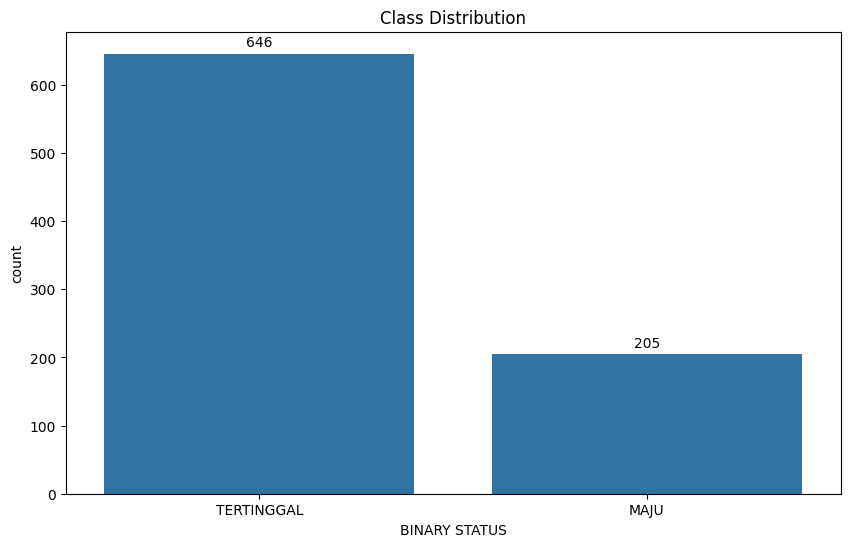

In [74]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='BINARY STATUS', data=idm_df_filtered)
plt.title('Class Distribution')
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

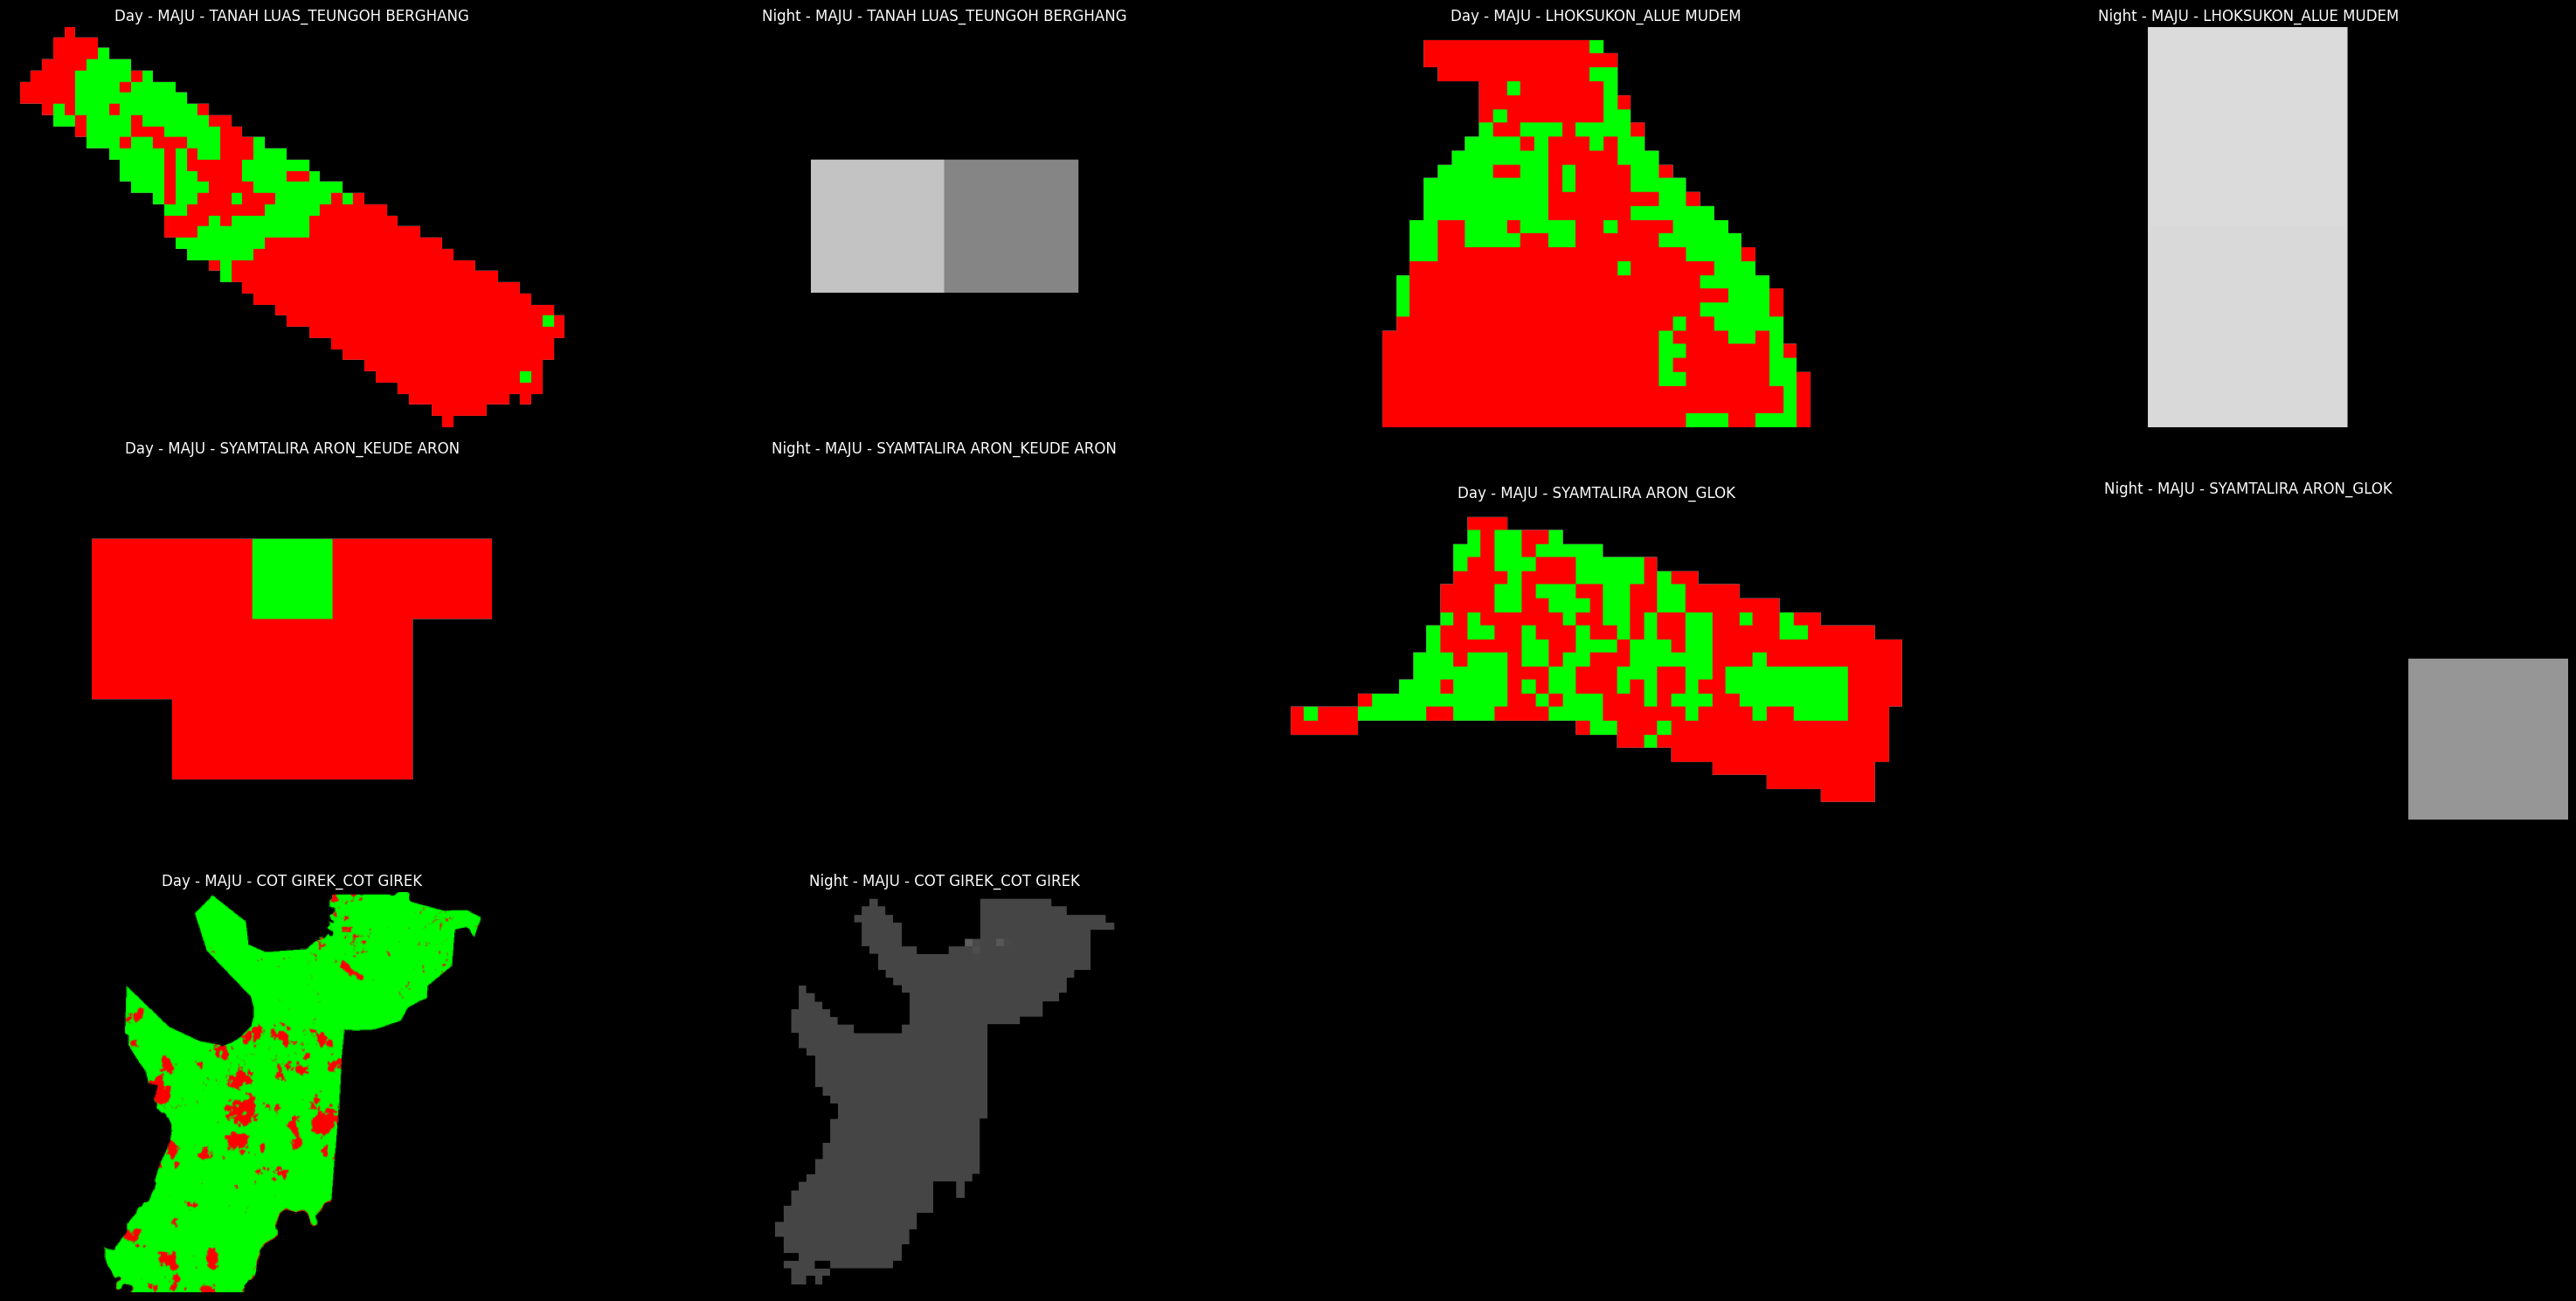

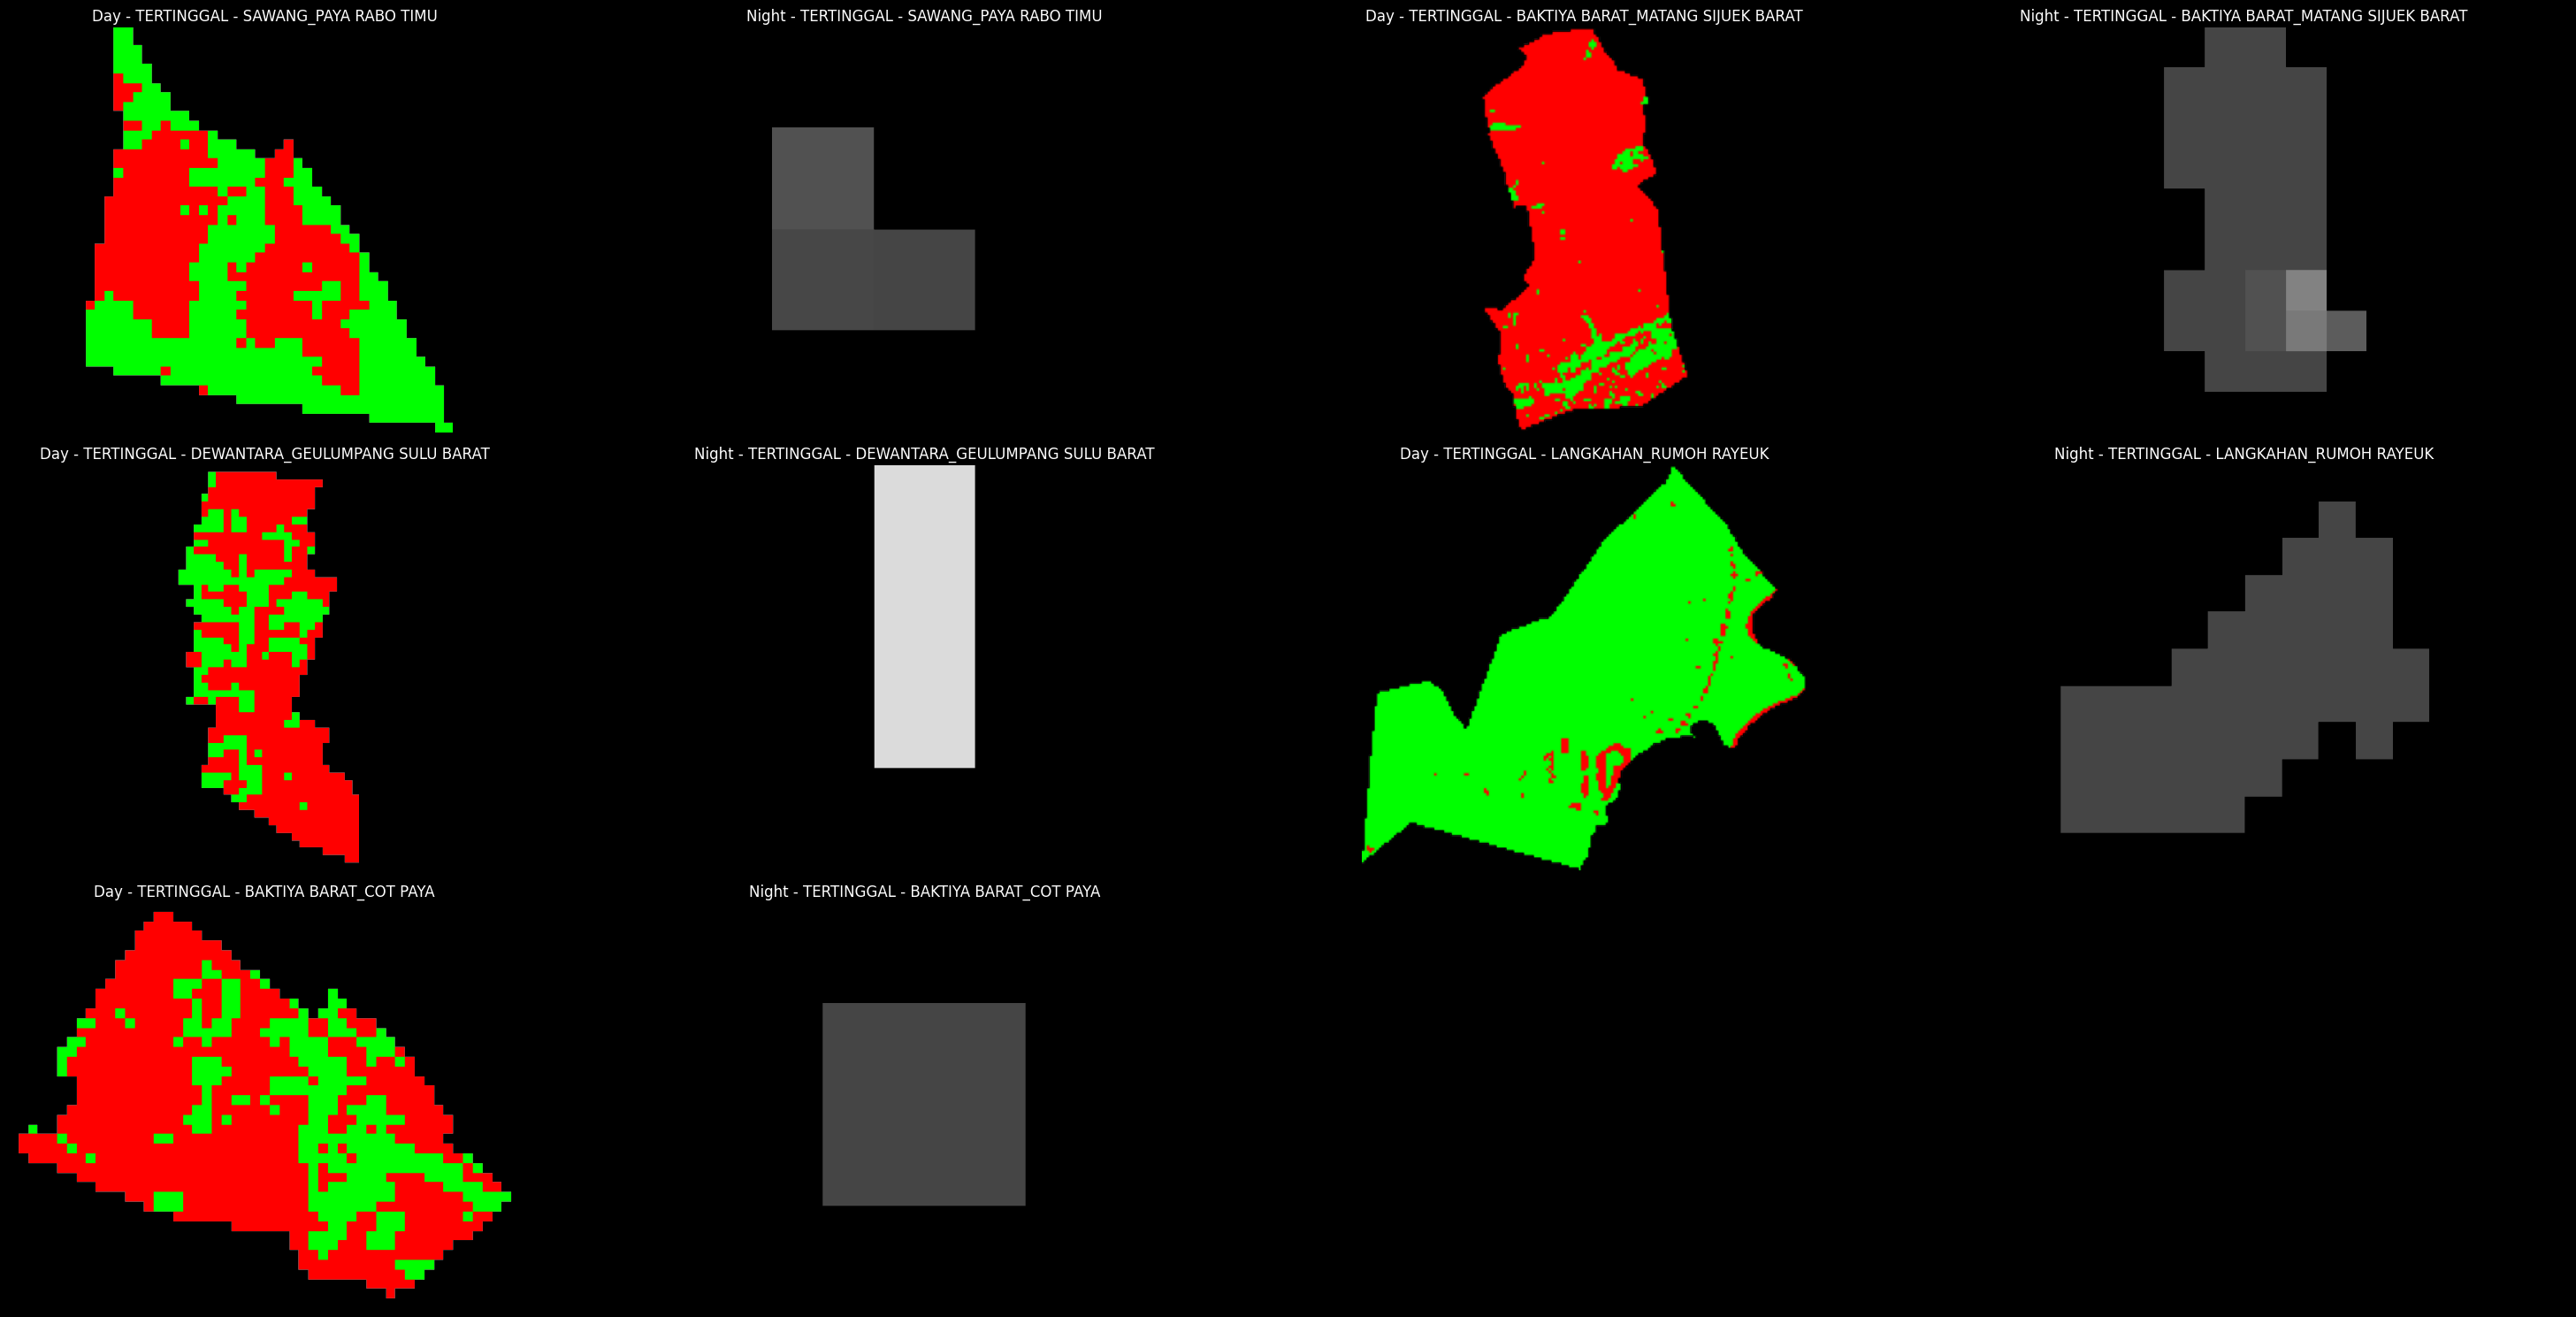

In [80]:
def show_sample_images(day_image_data, night_image_data, class_label, n=5, cols=2):
    class_images_day = day_image_data[day_image_data['status'] == class_label]
    class_images_night = night_image_data[night_image_data['status'] == class_label]
    
    common_villages = pd.merge(class_images_day, class_images_night, on='id')
    sample_villages = common_villages.sample(n)
    
    rows = (n // cols) + (n % cols > 0)
    fig, axes = plt.subplots(rows, cols*2, figsize=(30, 5*rows))
    fig.patch.set_facecolor('black')  # Set figure background color to black
    axes = axes.flatten()
    
    for i, (_, village_row) in enumerate(sample_villages.iterrows()):
        # Day images
        img_path_day = village_row['filepath_x']
        img_day = Image.open(img_path_day)
        ax_day = axes[i*2]
        ax_day.imshow(img_day)
        ax_day.set_title(f"Day - {class_label} - {village_row['kecamatan_x']}_{village_row['desa_x']}", color='white')
        ax_day.axis('off')
        ax_day.set_facecolor('black')  # Set axes background color to black
        
        # Night images
        img_path_night = village_row['filepath_y']
        img_night = Image.open(img_path_night)
        ax_night = axes[i*2 + 1]
        ax_night.imshow(img_night)
        ax_night.set_title(f"Night - {class_label} - {village_row['kecamatan_y']}_{village_row['desa_y']}", color='white')
        ax_night.axis('off')
        ax_night.set_facecolor('black')  # Set axes background color to black
    
    for ax in axes[len(sample_villages)*2:]:
        ax.axis('off')
        ax.set_facecolor('black')  # Set remaining axes background color to black
    
    plt.tight_layout()
    plt.show()

show_sample_images(day_images_metadata, night_images_metadata, 'MAJU', n=5, cols=2)
show_sample_images(day_images_metadata, night_images_metadata, 'TERTINGGAL', n=5, cols=2)

## Balancing Dataset

In [119]:
def normalize_path(path):
    return os.path.normpath(path)

def normalize_paths(df, path_column):
    df[path_column] = df[path_column].apply(normalize_path)
    return df

In [120]:
day_images_metadata = normalize_paths(day_images_metadata, 'filepath')
night_images_metadata = normalize_paths(night_images_metadata, 'filepath')

In [122]:
def augment_images_in_batches(image_paths, metadata_df, datagen, augment_size, batch_size=25):
    augmented_images = []
    metadata_augmented = []
    num_batches = len(image_paths) // batch_size + (len(image_paths) % batch_size > 0)
    
    for i in range(num_batches):
        batch_paths = image_paths[i * batch_size:(i + 1) * batch_size]
        batch_metadata = metadata_df[metadata_df['filepath'].isin(batch_paths)]

        for j, img_path in enumerate(batch_paths):
            img = Image.open(img_path).resize((255, 255))
            
            if img.mode == 'RGBA':
                img = img.convert('RGB')
            
            x = np.array(img)
            x = x.reshape((1,) + x.shape)
            
            for k, batch in enumerate(datagen.flow(x, batch_size=1)):
                augmented_img = batch[0]
                aug_filename = f"{os.path.basename(img_path).replace('.png', '-a.png')}"
                aug_filepath = os.path.join(os.path.dirname(img_path), aug_filename)

                augmented_images.append(augmented_img)

                # Update metadata for augmented images
                original_metadata = batch_metadata.iloc[j]
                metadata_augmented.append({
                    'id': original_metadata['id'],
                    'filename': aug_filename,
                    'filepath': aug_filepath,
                    'kecamatan': original_metadata['kecamatan'],
                    'desa': original_metadata['desa'],
                    'status': original_metadata['status'],
                    'original_filepath': img_path
                })

                if len(augmented_images) >= augment_size:
                    break

        if len(augmented_images) >= augment_size:
            break

    return augmented_images[:augment_size], pd.DataFrame(metadata_augmented)

In [123]:
augment_size = len(day_images_metadata[day_images_metadata['status'] == 'TERTINGGAL']) - len(day_images_metadata[day_images_metadata['status'] == 'MAJU'])
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [124]:
maju_day_images = day_images_metadata[day_images_metadata['status'] == 'MAJU']['filepath'].tolist()
maju_night_images = night_images_metadata[night_images_metadata['status'] == 'MAJU']['filepath'].tolist()

augmented_day_images, augmented_day_metadata = augment_images_in_batches(maju_day_images, day_images_metadata, datagen, augment_size)
augmented_night_images, augmented_night_metadata = augment_images_in_batches(maju_night_images, night_images_metadata, datagen, augment_size)

In [125]:
augmented_day_df = pd.DataFrame(augmented_day_metadata)
augmented_night_df = pd.DataFrame(augmented_night_metadata)

In [126]:
balanced_day_images_metadata = pd.concat([day_images_metadata, augmented_day_df], ignore_index=True)
balanced_night_images_metadata = pd.concat([night_images_metadata, augmented_night_df], ignore_index=True)

In [127]:
balanced_night_images_metadata

,id,filename,filepath,kecamatan,desa,status,original_filepath
0,1111010008,1111010008.png,Data\Dataset\NTL\MAJU\1111010008.png,SAWANG,SAWANG,MAJU,NaN
1,1111010023,1111010023.png,Data\Dataset\NTL\MAJU\1111010023.png,SAWANG,MEUNASAH PULO,MAJU,NaN
2,1111010024,1111010024.png,Data\Dataset\NTL\MAJU\1111010024.png,SAWANG,LHOK KUYUN,MAJU,NaN
3,1111010027,1111010027.png,Data\Dataset\NTL\MAJU\1111010027.png,SAWANG,BABAH BULOH,MAJU,NaN
4,1111010034,1111010034.png,Data\Dataset\NTL\MAJU\1111010034.png,SAWANG,ULEE GEUDONG,MAJU,NaN
...,...,...,...,...,...,...,...
1752,1111030027,1111030027-a.png,Data\Dataset\NTL\MAJU\1111030027-a.png,KUTA MAKMUR,BLANG RIEK,MAJU,Data\Dataset\NTL\MAJU\1111030027.png
1753,1111030028,1111030028-a.png,Data\Dataset\NTL\MAJU\1111030028-a.png,KUTA MAKMUR,MEUNASAH BLANG ARA,MAJU,Data\Dataset\NTL\MAJU\1111030028.png
1754,1111030029,1111030029-a.png,Data\Dataset\NTL\MAJU\1111030029-a.png,KUTA MAKMUR,KEUDE BLANG ARA,MAJU,Data\Dataset\NTL\MAJU\1111030029.png
1755,1111030030,1111030030-a.png,Data\Dataset\NTL\MAJU\1111030030-a.png,KUTA MAKMUR,KRUENG MANYANG,MAJU,Data\Dataset\NTL\MAJU\1111030030.png


In [128]:
balanced_day_images_metadata

,id,filename,filepath,kecamatan,desa,status,original_filepath
0,1111010008,1111010008-l.png,Data\Dataset\Daylight\MAJU\1111010008-l.png,SAWANG,SAWANG,MAJU,NaN
1,1111010008,1111010008-s.png,Data\Dataset\Daylight\MAJU\1111010008-s.png,SAWANG,SAWANG,MAJU,NaN
2,1111010023,1111010023-l.png,Data\Dataset\Daylight\MAJU\1111010023-l.png,SAWANG,MEUNASAH PULO,MAJU,NaN
3,1111010023,1111010023-s.png,Data\Dataset\Daylight\MAJU\1111010023-s.png,SAWANG,MEUNASAH PULO,MAJU,NaN
4,1111010024,1111010024-l.png,Data\Dataset\Daylight\MAJU\1111010024-l.png,SAWANG,LHOK KUYUN,MAJU,NaN
...,...,...,...,...,...,...,...
2603,1111020036,1111020036-l-a.png,Data\Dataset\Daylight\MAJU\1111020036-l-a.png,NISAM,BLANG KARIENG,MAJU,Data\Dataset\Daylight\MAJU\1111020036-l.png
2604,1111020036,1111020036-s-a.png,Data\Dataset\Daylight\MAJU\1111020036-s-a.png,NISAM,BLANG KARIENG,MAJU,Data\Dataset\Daylight\MAJU\1111020036-s.png
2605,1111022002,1111022002-l-a.png,Data\Dataset\Daylight\MAJU\1111022002-l-a.png,BANDA BARO,ALUE KEURINYAI,MAJU,Data\Dataset\Daylight\MAJU\1111022002-l.png
2606,1111022002,1111022002-s-a.png,Data\Dataset\Daylight\MAJU\1111022002-s-a.png,BANDA BARO,ALUE KEURINYAI,MAJU,Data\Dataset\Daylight\MAJU\1111022002-s.png


In [51]:
def load_images(filenames):
    images = []
    for filename in filenames:
        img = load_img(filename, target_size=(224, 224))
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

sentinel_filenames = balanced_day_images_metadata[balanced_day_images_metadata['filename'].str.contains('-s')]['filepath'].tolist()
landsat_filenames = balanced_day_images_metadata[balanced_day_images_metadata['filename'].str.contains('-l')]['filepath'].tolist()
night_filenames = balanced_night_images_metadata['filepath'].tolist()

In [52]:
X_sentinel_images = load_images(sentinel_filenames)
X_landsat_images = load_images(landsat_filenames)
X_night_images = load_images(night_filenames)

TypeError: path should be path-like or io.BytesIO, not <class 'float'>

In [20]:
def generator_to_tf_dataset(generator, batch_size):
    output_signature = (
        (tf.TensorSpec(shape=(batch_size, 255, 255, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(batch_size, 255, 255, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)
    )
    
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )
    
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

train_combined_ds = generator_to_tf_dataset(train_combined_gen, 32)
test_combined_ds = generator_to_tf_dataset(test_combined_gen, 32)

In [21]:
for (day_batch, night_batch), labels in train_combined_gen:
    print("Day batch shape:", day_batch.shape)
    print("Night batch shape:", night_batch.shape)
    print("Labels shape:", labels.shape)
    break

Day batch shape: (32, 255, 255, 3)
Night batch shape: (32, 255, 255, 3)
Labels shape: (32,)


## Train Model

In [22]:
input_day = Input(shape=(255, 255, 3), name='day_input')
input_night = Input(shape=(255, 255, 3), name='night_input')

def build_cnn_branch(input_tensor):
    x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    return x

branch_day = build_cnn_branch(input_day)
branch_night = build_cnn_branch(input_night)

combined = Concatenate()([branch_day, branch_night])
output = Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[input_day, input_night], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(
    train_combined_ds,
    epochs=5,
    validation_data=test_combined_ds
)

Epoch 1/5


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 255, 255, 3), found shape=(None, 32, 255, 255, 3)